In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import os
from tqdm import tqdm
from random import sample
from swarm_sim import *

In [2]:
#========================== GLOBAL VARIABLES ==============================
PATH = '../data/Topologies/topology_low_sat50.csv'

CONNECTION_RANGE = 30 # km
NB_NODES = 50

In [9]:
def plot_edges(swarm, n_color='gray', weighted=False):
    colors = ['blue','green','red','black']
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_zlabel('z (km)')
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=50, edgecolor='black')
    
    if not weighted:
        for node in swarm.nodes:
            for n in node.neighbors:
                ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c=colors[0])
    else:
        for n1 in swarm.nodes:
            for (n2, weight) in n1.neighbors:
                ax.plot([n1.x, n2.x], [n1.y, n2.y], [n1.z, n2.z], c=colors[int(np.sqrt(weight)) -1])
                

In [4]:
df_topo = pd.read_csv(PATH, sep=',', header=0, index_col='sat_id')
df_topo.head()

,x,y,z
sat_id,,,
0,-2202.426393,3002.727844,2716.061827
1,-2065.627696,3138.612087,2649.212988
2,-2144.531293,3083.183842,2667.738099
3,-2132.168342,3089.558746,2663.544806
4,-2127.308940,3094.974752,2628.184405


In [5]:
swarm = Swarm(
    connection_range=CONNECTION_RANGE,
    nodes=[Node(i, df_topo.iloc[i].x, df_topo.iloc[i].y, df_topo.iloc[i].z) for i in list(df_topo.index.values)]
)
print(swarm)

Swarm of 50 node(s), connection range: 30


Computing neighbor matrix.


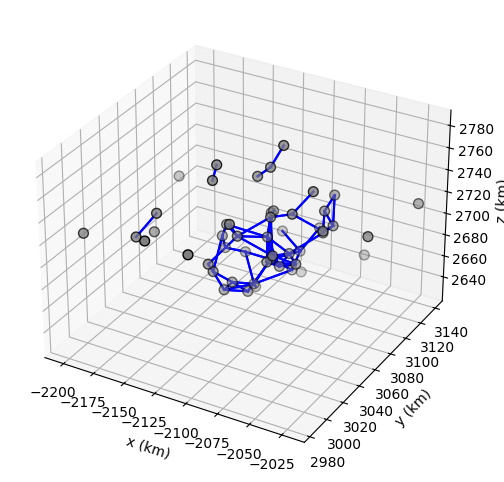

In [6]:
swarm.reset_connection()
print('Computing neighbor matrix.')
matrix = swarm.neighbor_matrix()
plot_edges(swarm)

In [7]:
def is_neighbor(n1, n2, connection_range=0, weight=None):
    if n2.id != n1.id:
        if n1.compute_dist(n2) <= connection_range:
            if weight:
                n1.add_neighbor((n2,weight))
            else:
                n1.add_neighbor(n2)
            return 1 
        if weight:
            n1.remove_neighbor((n2,weight))
        else:
            n1.remove_neighbor(n2)
    return 0

def isolated_nodes(swarm):
    return [node for node in swarm.nodes if len(node.neighbors)==0]

def find_closest_neighbors(swarm, node, connection_range):
    coef = 0
    neighbors = []
    while len(neighbors)==0:
        coef += 1
        distances = [(n2, node.compute_dist(n2)) for n2 in swarm.nodes]
        neighbors = [d[0] for d in distances if d[1]<=coef*connection_range and d[1]>0]
    print('Node', node.id, ': found', len(neighbors), 'neighbors at', coef*connection_range, 'km.')
    return (neighbors, coef)
    
def neighbor_matrix(swarm, connection_range=None, weighted=False):
        matrix = []
        if not connection_range:
            connection_range=swarm.connection_range # Use the attribute of the Swarm object if none specified
        for node in swarm.nodes:
            matrix.append([is_neighbor(node, nb, connection_range, weighted) for nb in swarm.nodes])
            
        if weighted:
            for node in isolated_nodes(swarm):
                (neighbors, coef) = find_closest_neighbors(swarm, node, connection_range)
                for n in neighbors:
                    matrix[node.id][n.id] = is_neighbor(node, n, coef*connection_range, weight=pow(coef,2))
        return matrix

Node 0 : found 3 neighbors at 60 km.
Node 1 : found 5 neighbors at 60 km.
Node 5 : found 3 neighbors at 60 km.
Node 6 : found 3 neighbors at 60 km.
Node 13 : found 9 neighbors at 60 km.
Node 21 : found 8 neighbors at 60 km.
Node 26 : found 1 neighbors at 60 km.
Node 29 : found 5 neighbors at 60 km.
Node 32 : found 10 neighbors at 60 km.


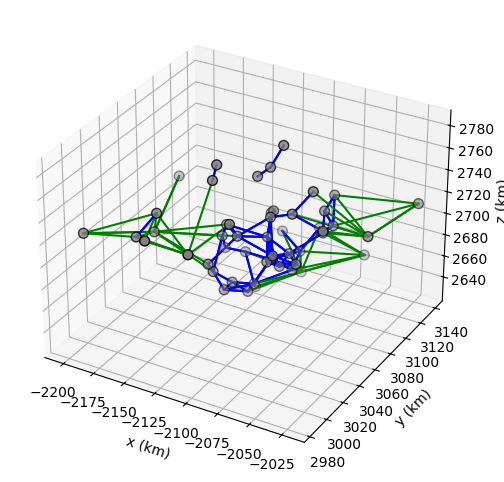

In [18]:
swarm.reset_connection()
weighted_matrix = neighbor_matrix(swarm, connection_range=CONNECTION_RANGE, weighted=True)
plot_edges(swarm, weighted=True)

In [16]:
def swarm_to_weighted_graph(swarm):
    G = nx.Graph()
    G.add_nodes_from([n.id for n in swarm.nodes])
    visited = []
    for ni in swarm.nodes:
        for (nj, w) in ni.neighbors:
            if ni.id != nj.id and set((ni.id, nj.id)) not in visited:
                visited.append((ni.id,nj.id))
                G.add_edge(ni.id, nj.id, weight=w)
    return G

Graph with 50 nodes and 110 edges


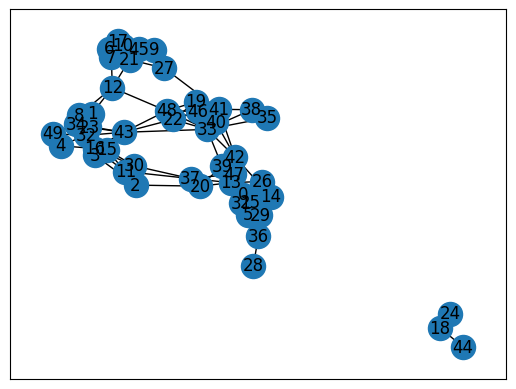

In [22]:
graph = swarm_to_weighted_graph(swarm)
print(graph)
nx.draw_networkx(graph)

In [25]:
graph.get_edge_data(0,13)['weight']

4

In [26]:
def swarm_betweeness_centrality(graph):
    bc = nx.betweenness_centrality(graph)
    bc_dict = {
        'Node':list(bc.keys()),
        'BC':list(bc.values())
    }
    return bc_dict


def kronecker_delta(ni, nj):
    if ni.group==nj.group:
        return 1
    return 0


def modularity(graph):
    nb_edges = nx.number_of_edges(graph)
    element = 0
    for ni in graph.nodes:
        for nj in graph.nodes:
            adj = 0
            delta = 1 # Same group for everyone
            if graph.has_edge(ni,nj):
                adj = 1
            element += (adj - nx.degree(graph,ni)*nx.degree(graph,nj)/(2*nb_edges)) * delta
    modularity = element / (2*nb_edges)
    return modularity


def origin_destination_pairs():
    return NB_NODES*(NB_NODES-1)/2


def pair_disparity(shortest_paths:list, spl:int):
    if len(shortest_paths)==1:
        return 0.0
    path_graphs = {}
    for i,path in enumerate(shortest_paths):
        path_graphs[i] = nx.path_graph(path)
    disparity = 0
    pairs = []
    for idx1,p1 in path_graphs.items():
        for idx2,p2 in path_graphs.items():
            if idx1 != idx2 and set([idx1,idx2]) not in pairs:
                pairs.append(set([idx1,idx2]))
                its = nx.intersection(p1,p2)
                disp = 1 - nx.number_of_edges(its)/spl
                disparity += disp
    return disparity/len(pairs)

In [29]:
def pair_efficiency(G, u, v, weight='weight'):
    try:
        eff = 1 / nx.shortest_path_length(G, u, v, weight=weight)
    except nx.NetworkXNoPath:
        eff = 0
    return eff

In [30]:
visited_pairs, paths = [], []
redundancies = []
disparities = []
total_spl = 0
eff = 0.0
nb_max = origin_destination_pairs()
        
for src_id in graph.nodes:
    for dst_id in graph.nodes:
        if dst_id != src_id and set((src_id,dst_id)) not in visited_pairs:  
            visited_pairs.append(set((src_id,dst_id))) 
            pair_red = 0
            eff += pair_efficiency(graph, src_id, dst_id, weight='weight')
            if nx.has_path(graph, src_id, dst_id):
                paths.append(set((src_id,dst_id))) 
                spl = nx.shortest_path_length(graph, source=src_id, target=dst_id, weight='weight')
                shortest_paths = list(nx.all_shortest_paths(graph, src_id, dst_id, weight='weight'))
                pair_red += len(shortest_paths)
                pair_disp = pair_disparity(shortest_paths, spl)
                total_spl += spl

                redundancies.append(pair_red)
                disparities.append(pair_disp)

In [31]:
flow = len(paths)/nb_max
mod = modularity(graph)
df_bc = pd.DataFrame(swarm_betweeness_centrality(graph))
crit = len(df_bc[df_bc['BC']>=0.05]['BC'])
cost = total_spl*2
global_eff = eff/nb_max